In [81]:
# %matplotlib notebook
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display,clear_output
import multiprocessing
import time


In [82]:
class Unit:
    def __init__(self, field,x, y, pheremone_strength, speed, power, attack_range):
        self.x = x
        self.y = y
        self.field = field
        self.health = 10
        self.attack_range = attack_range
        self.speed = speed
        self.power = power
        self.history = [(x,y)]
        self.kill_count = 0
        self.time_alive = 0
        self.food_count = 0
        self.has_food = False

        self.heading = random.randint(0, 359)

    def move(self):

        # if self.has_food:
        #     self.return_to_nest()
        # else:
        #     self.search_for_food()

        self.heading += random.randint(-40, 40)
        self.forward()

    def forward(self):
        new_x = self.x + math.cos(math.radians(self.heading))
        new_y = self.y + math.sin(math.radians(self.heading))

        # Check if the new position is within the bounds of the world
        if 0 <= new_x < self.field.width and 0 <= new_y < self.field.height:
            self.x = new_x
            self.y = new_y
        else:
            # If the new position is outside the bounds, adjust it to stay within the bounds
            self.x = max(0, min(new_x, self.field.width - 1))
            self.y = max(0, min(new_y, self.field.height - 1))

        self.history.append((self.x,self.y))
        # define funtionality for moving by updating position and adding position tuple to history array
        # calculate the move by using the parameters plus the "pheremone"

    def attack(self):
        enemies = self.world.swarms[0] if self.world.swarms[0] != self else self.world.swarms[1]
        for enemy in enemies.units:
            if enemy != self:
                distance = math.sqrt((self.x - enemy.x)**2 + (self.y - enemy.y)**2)
                if distance <= self.attack_range:
                    enemy.health -= self.power
        # check if any enemy units are in a certain range
        # implement logic to choose which enemy to attack

    def death(self):
        dummy = 0
        # implement logic upon unit death

    def update_plot(self, frame):
        # Plot current position
        x, y = self.history[frame]
        self.marker.set_data(x, y)
        return (self.marker,)

    def plot_position_history(self):
        # Create figure and axis
        fig, ax = plt.subplots()

        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)

        # Plot initial position
        x, y = self.history[0]
        (self.marker,) = ax.plot(x, y, "bo", markersize=10)

        # Create animation
        ani = animation.FuncAnimation(
            fig, self.update_plot, frames=len(self.history), interval=100, blit=True
        )
        display(HTML(ani.to_html5_video()))
        # Show animation

In [83]:
# unit = Unit((3, 3), 0, 0, 0,0)

# # Move the unit
# for i in range(10):
#     unit.move()



# # Display animation
# unit.plot_position_history()


In [84]:
# class resourceNode:
#     def __init__(self, position, max_resources):
#         self.position = position
#         self.max_resources = max_resources
#         self.current_resources = max_resources

#     def deplete(self, amount):
#         self.current_resources -= amount
#         if self.current_resources < 0:
#             self.current_resources = 0

In [85]:
class Swarm:
    def __init__(
        self,
        field,
        max_units,
        start_x,
        start_y
    ):
        self.max_units = max_units
        self.field = field
        self.active_units = []
        self.dead_units = []
        self.pheromone_map = (field.width, field.height)
        self.x = start_x
        self.y = start_y
        self.populate_swarm()
    def processing_move(unit):
        unit.move()
    def populate_swarm(self):
        dummy = 0
        for i in range(self.max_units):
            speed = random.uniform(0, 1)
            power = random.randint(1, 5)
            attack_range = random.uniform(0.5, 3)
            p_strength = random.randint(1, 3)
            ant = Unit(self.field,self.x,self.y,p_strength, speed, power, attack_range)
            self.active_units.append(ant)
        # populate swarm and initialize random stats for each unit

    # def move(self):
    #     # Implement movement logic for the entire swarm by working through array
    #     pool = multiprocessing.Pool()
    #     pool.map(processing_move,units)
    #     pool.close()
    #     pool.join()
    #     pass
    def check_death(self):
        for unit in self.active_units:
            if unit.health<= 0:
                self.active_units.remove(unit)
                self.dead_units.append(unit)
                
    def gather_resources(self, resource_nodes):
        # Implement resource gathering logic for the entire swarm by working through array
        pass

    def update(self):
        # Implement any other updates for the swarm i cant think of anything but here is extra stuff
        pass

In [86]:
class Battlefield:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.resource_nodes = []
        self.swarms = []
        self.tick_count = 0
        self.evolution = 0

        self.swarms.append(Swarm(self, 20, 0, 0))
        self.swarms.append(Swarm(self, 20, 90, 90))

        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim(0,width)
        self.ax.set_ylim(0,height)
        self.sc1 = self.ax.scatter([], [], color=["red"], label=["Class 1"])
        self.sc2 = self.ax.scatter([], [], color=["blue"], label=["Class 2"])

    def process_move(self, swarm):
        swarm.move()

    def process_attack(swarm):
        random.shuffle(swarm.active_units)
        for ant in swarm.active_units:
            ant.attack()

    def populate_resources(self, node):
        dummy = 0
        # populate the resources across the search space

    def create_teams(self, swarm):
        dummy = 0
        # create two swarm by calling swarm

    def tick(self):
        # pool = multiprocessing.Pool()
        # pool.map(self.process_move, self.swarms)
        # pool.close()
        # pool.join()
        for ant in self.swarms[0].active_units:
            ant.move()
        for ant in self.swarms[1].active_units:
            ant.move()
        # pool = multiprocessing.Pool()
        # pool.map(self.process_attack, self.swarm.active_units)
        # this may be a problem late
        # pool.map(
        #     self.process_attack,
        #     [self.swarm[0].active_units, self.swarm[1].active_units],
        # )
        #  for ant in swarm.active_units:
        #     ant.attack()
        self.tick_count += 1
        # self.visualize(0)

    def simulate(self, num_iterations):
        """ "   #for _ in range(num_iterations):
        # Update each swarm
        for swarm in self.swarms:
            swarm.move()
            swarm.gather_resources(self.resource_nodes)
            swarm.update()
        #just keep track of the position history and the history of each unit
        # Visualization code (optional)
        self.visualize()"""

    def visualize(self):
        # # Visualization code to plot the battlefield, units, and resource nodes
        # self.tick()
        # if self.tick_count > 10:
        #     raise StopIteration
        class1_coords = [[ant.x, ant.y] for ant in self.swarms[0].active_units]
        class2_coords = [[ant.x, ant.y] for ant in self.swarms[1].active_units]

        self.sc1.set_offsets(class1_coords)
        self.sc2.set_offsets(class2_coords)

        display(self.fig)
        clear_output(wait=True)
        # time.sleep(.1)



In [87]:
# class SwarmPlotter:
#     def __init__(self, history):
#         self.history = history
#         self.markers = []

#     def update_plot(frame):
#         # Plot current position
#         for idx, marker in enumerate(self.markers):
#             x, y = self.history[idx][frane]
#             marker.set_data(x, y)
#         return self.markers

#     def plot_position_history(field):
#         # Create figure and axis
#         fig, ax = plt.subplots()

#         ax.set_xlim(0, 5)
#         ax.set_ylim(0, 5)
#         """'
#             # Plot initial position
#             for p
#             x, y = self.history[0]
#             (self.marker,) = ax.plot(x, y, "bo", markersize=10)

#             # Create animation
#             ani = animation.FuncAnimation(
#                 fig, self.update_plot, frames=len(self.history), interval=100, blit=True
#             )"""
#         for idx, pos_history in enumerate(self.history):
#             x, y = pos_history[frame]
#             (marker,) = ax.plot(x, y, "bo", markersize=5)
#             self.markers.append(marker)
#         display(HTML(ani.to_html5_video()))
#         # Show animation


# def run(bf: Battlefield):
#     bf.tick()
#     return bf.visualize()


def main():
    import matplotlib.animation as animation

    bf = Battlefield(100, 100)
    for _ in  range(1000):
        bf.tick()
        bf.visualize()

        

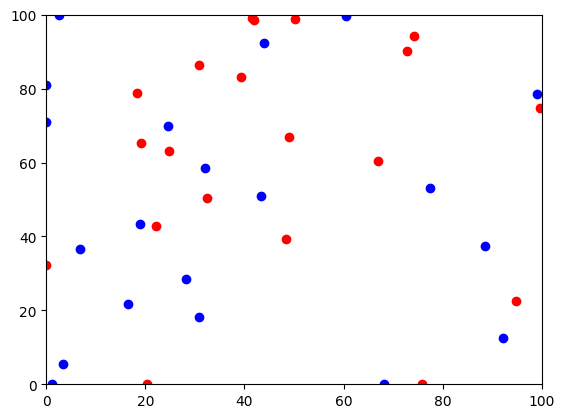

In [88]:
#real shit
if __name__ == "__main__":
    main()

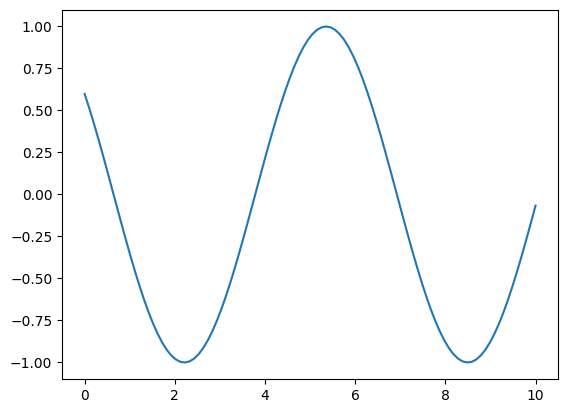

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Enable interactive plots
# %matplotlib notebook

# Create initial data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and axis
fig, ax = plt.subplots()
line, = ax.plot(x, y)

# Update function
def update_plot():
    y = np.sin(x + update_plot.counter / 10.0)
    line.set_ydata(y)
    ax.relim()
    ax.autoscale_view()
    display(fig)
    clear_output(wait=True)
    time.sleep(0.1)  # Adjust the delay as needed
    update_plot.counter += 1

update_plot.counter = 0

# Continuous update loop
try:
    while True:
        update_plot()
except KeyboardInterrupt:
    pass
